# Summary of work
After determining the internal similarities of various Classyfire classes and NPClassifier classes using Jaccard score and Spec2Vec similarity, the point was raised that it would be very interesting to see how these compare to the supervised embeddings produced by MS2DeepScore. Calculating the embeddings takes a while, so I wrote a script that uses parallel computation to speed up the process. Whereas Spec2Vec drastically underestimates the similarity of all but highly similar compounds, MS2DeepScore slightly overestimates the similarity. Setting the cut-off value for “high similarity” just slightly higher (0.65 instead of 0.6) however, created a nice correlation with the percentage of pairs exceeding 0.6 Jaccard similarity. This was true for both NPClassifier classes, and Classyfire classes, suggesting this threshold might generalize to other datasets.

# Load libraries and data

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import percentileofscore

from processing import get_ids_for_unique_inchikeys

# Specify directories
data_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Data/"
embedding_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Embeddings/"
model_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Model/"
plot_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Plots/"

# Define functions
def ms2ds_similarity_for_groups(metadata_df, var, spectra, min_class_size=50):
    class_count = metadata_df[var].value_counts(ascending=False)
    selected_classes = class_count[class_count>=min_class_size]
    similarity_measure = MS2DeepScore(model)
    print(len(selected_classes), "classes exceed minimum class size")

    ms2ds_array = []
    for group in selected_classes.index:
        selection = metadata_df[metadata_df[var] == group]
        spectra_selection = [spectra[i] for i in selection.index]
        similarity_matrix = calculate_scores(spectra_selection, spectra_selection, similarity_function=similarity_measure, is_symmetric=True).scores
        similarity_triangle = similarity_matrix[np.triu_indices(n=len(selection))]
        ms2ds_array += [similarity_triangle]
    return selected_classes, ms2ds_array

def flatten(t):
    return [item for sublist in t for item in sublist]

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize = 8) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [9]:
# Load original spectra file
spectra = pd.read_pickle(data_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v.pickle")

# Load model
model = load_model(model_dir+"ms2ds_model_20210419-221701_data210409_10k_500_500_200.hdf5")
similarity_measure = MS2DeepScore(model)

# Load the class predictions for each inchikey
inchikey_classifications = pd.read_csv(data_dir+"ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt", sep = "\t")
inchikey_classifications.rename(columns = {"inchi_key": "inchikey"}, inplace = True) 

In [ ]:
# Load internal Jaccard similarity scores
internal_scores = pd.read_csv(data_dir+"Internal jaccard similarity per classification group.csv", sep = ",", index_col = 0)
npc_jaccard = internal_scores.query('Classification == "NPClassifier classes"')["Score"]
cf_jaccard = internal_scores.query('Classification == "Classyfire classes"')["Score"]

# Load internal spec2vec similarity
internal_scores = pd.read_csv(data_dir+"Internal spec2vec similarity per classification group.csv", sep = ",", index_col = 0)
npc_cosine = internal_scores.query('Classification == "NPClassifier classes"')["Score"]
cf_cosine = internal_scores.query('Classification == "Classyfire classes"')["Score"]

# Get spectrum metadata

In [10]:
# Get metadata; we retrieve the inchikey and source instrument for all spectra, and look up the predicted classes for the inchikey.
spectrum_id = []; inchikeys = []; inchi = []; instruments = []

for spec in spectra:
    inchikeys.append(spec.get("inchikey"))
    inchi.append(spec.get("inchi"))
    instruments.append(spec.get("instrument"))
    spectrum_id.append(spec.get("spectrum_id"))
spectrum_metadata = pd.DataFrame({"ID": spectrum_id, "inchikey":inchikeys, "inchi": inchi, "instrument": instruments})

# We drop all spectral records without inchikey and match the remaining records with npclassifier and classyfire compound class predictions
spectrum_metadata['spectrum_index'] = spectrum_metadata.index # Merging dataframes changes the row order, so we're saving the index now as a column to restore it after merging
spectrum_metadata = spectrum_metadata[spectrum_metadata["inchikey"] != ""]
spectrum_metadata = spectrum_metadata.merge(inchikey_classifications, how='left', on='inchikey', sort=False).sort_values(by="spectrum_index")

spectrum_metadata["planar_inchi"] = [key[:14] for key in spectrum_metadata["inchikey"]] # Add shortened planar inchikey to metadata
inchi_spectra = [spectra[i] for i in spectrum_metadata["spectrum_index"]] # Subset the spectra to only the spectra with inchikeys
print(len(inchi_spectra), "out of", len(spectra), "spectra are annotated with an Inchikey")
spectrum_metadata.reset_index(drop = True, inplace = True) # Match indices to inchi_spectra indices

# We retrieve the IDs of spectra with unique planar Inchikeys
unique_inchi = get_ids_for_unique_inchikeys(inchi_spectra)
print(f'{len(unique_inchi)} out of {len(inchi_spectra)} annotated spectra have a unique Inchikey')

# Quick check to see that the spectra and spectrum_metadata match up
print("Spectra and metadata match:", inchi_spectra[17000].get("spectrum_id") == spectrum_metadata["ID"][17000])

187152 out of 199780 spectra are annotated with an Inchikey
16360 out of 187152 annotated spectra have a unique Inchikey
Spectra and metadata match: True


In [7]:
# Retrieve SpectrumDocuments
spectrum_documents = [spec2vec.SpectrumDocument(s, n_decimals=2) for i, s in enumerate(inchi_spectra)]

# MS2DeepScore similarity for NPClassifier classes

In [ ]:
npc_classes, npc_ms2ds_scores = ms2ds_similarity_for_groups(spectrum_metadata.iloc[unique_inchi], var = "npc_class_results", spectra = inchi_spectra, min_class_size=50)
npc_ms2d = 100-pd.Series([percentileofscore(group, 0.5, kind = "rank") for group in npc_ms2ds], index = npc_classes.index).sort_values()
#npc_ms2ds.to_csv(data_dir+"Internal MS2DS similarities - NPClassifier classes.csv", sep = "\t")

In [96]:
npc_ms2ds = pd.read_csv(data_dir+"Internal MS2DS similarities - NPClassifier classes.csv", sep = "\t", index_col = 0)

In [145]:
npc_ms2ds = 100-pd.Series([percentileofscore(group, 0.65, kind = "rank") for group in npc_ms2ds_scores], index = npc_classes.index).sort_values()

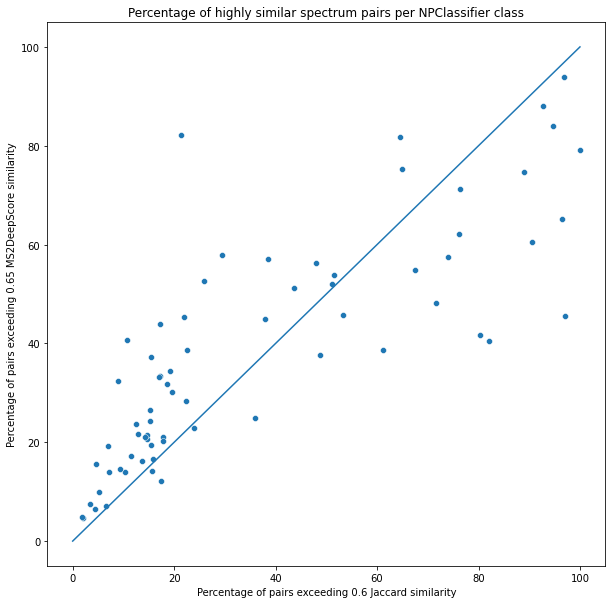

In [165]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=npc_jaccard, y=npc_ms2ds)
sns.lineplot(x = [0, 100], y = [0, 100])
plt.xlabel("Percentage of pairs exceeding 0.6 Jaccard similarity")
plt.ylabel("Percentage of pairs exceeding 0.65 MS2DeepScore similarity")
plt.title("Percentage of highly similar spectrum pairs per NPClassifier class")
plt.savefig(plot_dir+"Save1.jpg")

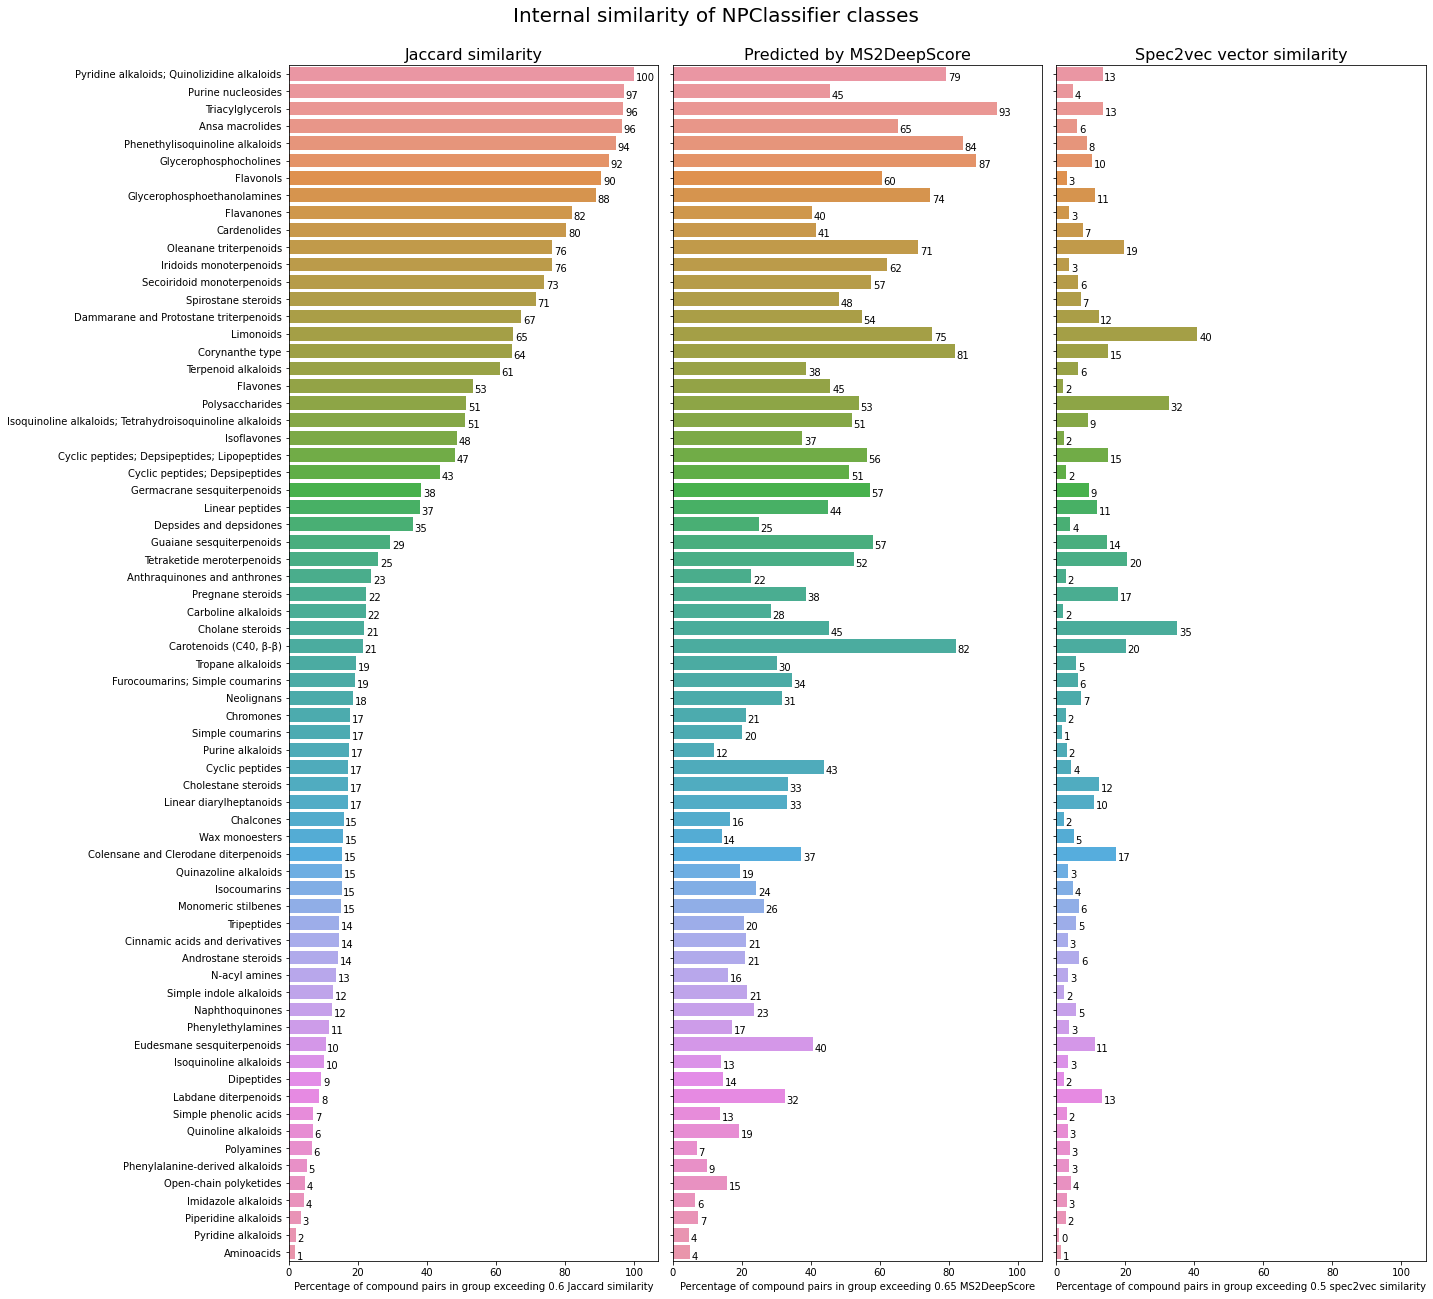

In [157]:
f, axes = plt.subplots(1, 3, figsize=(20, 18), gridspec_kw={'width_ratios': [1, 1, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)
plt.suptitle("Internal similarity of NPClassifier classes", fontsize = 20, y=1.00)

fig1 = sns.barplot(x = npc_jaccard.values, y = npc_jaccard.index, ax = axes[0])
fig1.set_title("Jaccard similarity", fontsize=16)
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_xlim(0,107)
show_values_on_bars(fig1, "h", 0.5)

npc_ms2ds = npc_ms2ds.reindex(npc_jaccard.index)
fig2 = sns.barplot(x = npc_ms2ds.values, y = npc_ms2ds.index, ax = axes[1])
fig2.set_title("Predicted by MS2DeepScore", fontsize=16)
fig2.set_xlabel('Percentage of compound pairs in group exceeding 0.65 MS2DeepScore')
fig2.set_xlim(0,107)
show_values_on_bars(fig2, "h", 0.5)
fig2.set_yticklabels([])

npc_cosine = npc_cosine.reindex(npc_jaccard.index)
fig3 = sns.barplot(x = npc_cosine["0"].values, y = npc_cosine.index, ax = axes[2])
fig3.set_title("Spec2vec vector similarity", fontsize=16)
fig3.set_xlabel('Percentage of compound pairs in group exceeding 0.5 spec2vec similarity')
fig3.set_xlim(0,107)
show_values_on_bars(fig3, "h", 0.5)
fig3.set_yticklabels([]);

plt.tight_layout()
plt.savefig(plot_dir+"Internal similarities Jaccard, MS2DS, spec2vec - NPClassifier classes.jpg")

# MS2DeepScore similarity for Classyfire classes

In [ ]:
cf_classes, cf_ms2ds_scores = ms2ds_similarity_for_groups(spectrum_metadata.iloc[unique_inchi], var = "cf_class", spectra = inchi_spectra, min_class_size=50)
cf_ms2ds = 100-pd.Series([percentileofscore(group, 0.5, kind = "rank") for group in cf_ms2ds_scores], index = cf_classes.index).sort_values()
#cf_ms2ds.to_csv(data_dir+"Internal MS2DS similarities - Classyfire classes.csv", sep = "\t")

In [101]:
cf_ms2ds = pd.read_csv(data_dir+"Internal MS2DS similarities - Classyfire classes.csv", sep = "\t", index_col = 0)

In [159]:
cf_ms2ds = 100-pd.Series([percentileofscore(group, 0.65, kind = "rank") for group in cf_ms2ds_scores], index = cf_classes.index).sort_values()

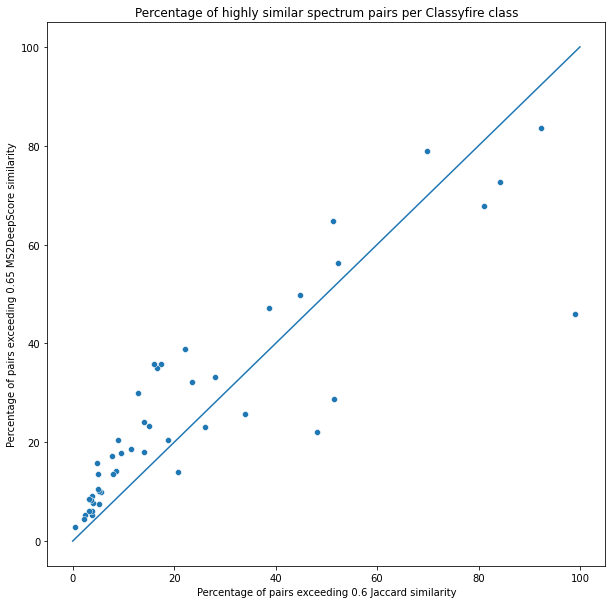

In [164]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=cf_jaccard, y=cf_ms2ds)
sns.lineplot(x = [0, 100], y = [0, 100])
plt.xlabel("Percentage of pairs exceeding 0.6 Jaccard similarity")
plt.ylabel("Percentage of pairs exceeding 0.65 MS2DeepScore similarity")
plt.title("Percentage of highly similar spectrum pairs per Classyfire class")
plt.savefig(plot_dir+"Save2.jpg")

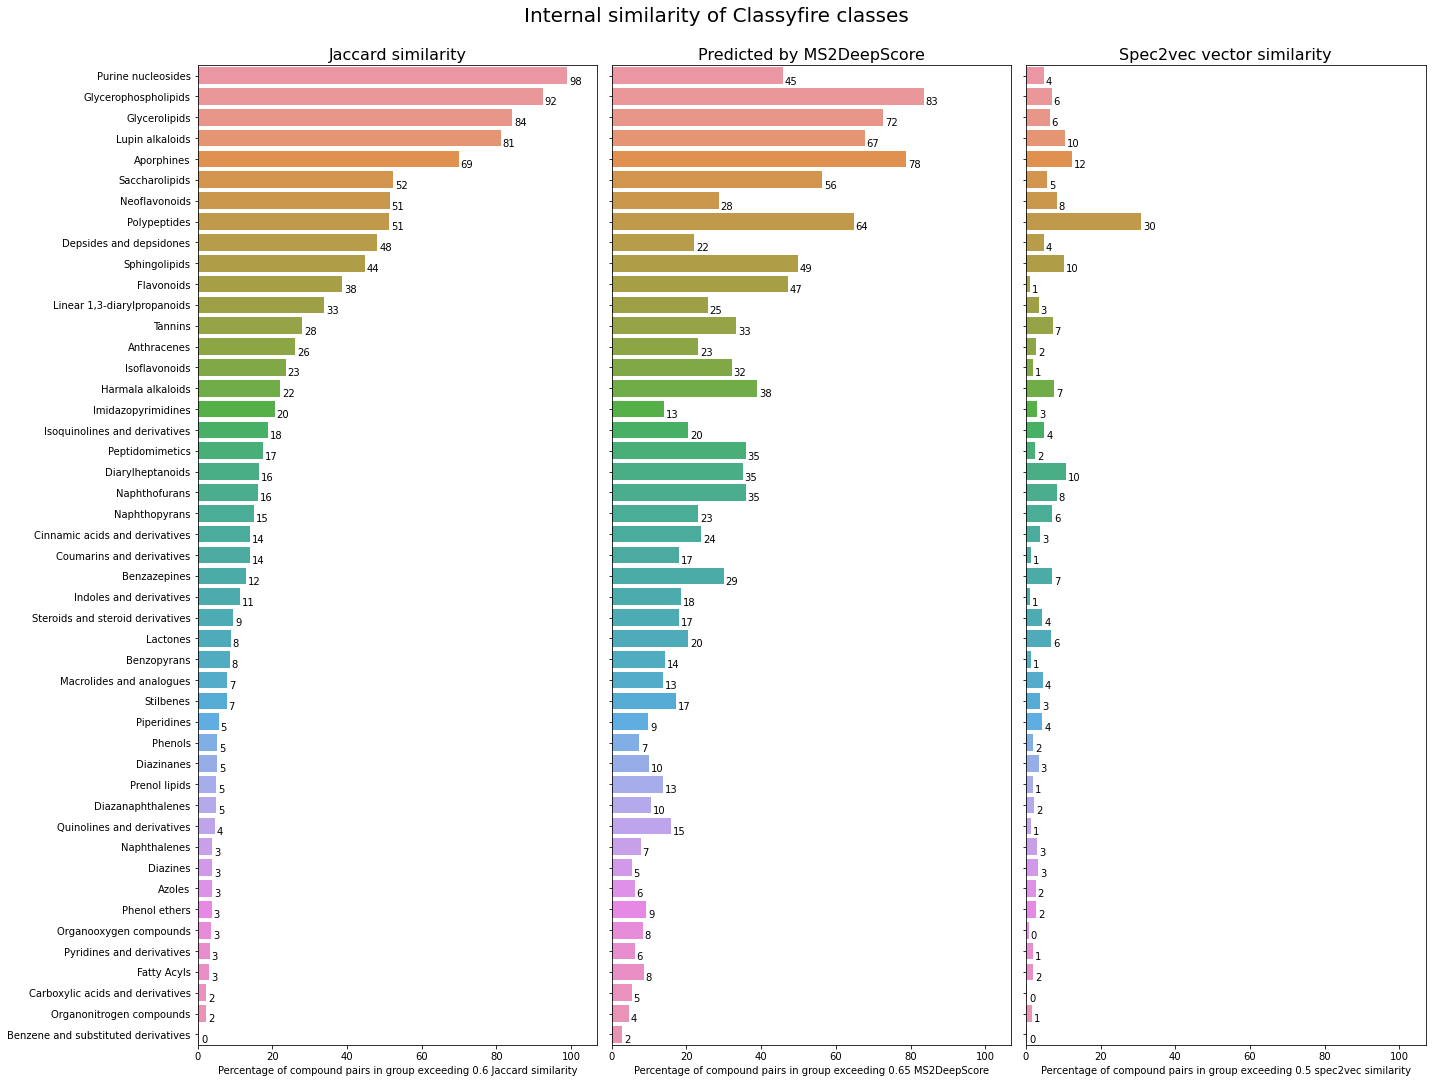

In [162]:
f, axes = plt.subplots(1, 3, figsize=(20, 15), gridspec_kw={'width_ratios': [1, 1, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)
plt.suptitle("Internal similarity of Classyfire classes", fontsize = 20, y=1.00)

fig1 = sns.barplot(x = cf_jaccard.values, y = cf_jaccard.index, ax = axes[0])
fig1.set_title("Jaccard similarity", fontsize=16)
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_xlim(0,107)
show_values_on_bars(fig1, "h", 0.5)

cf_ms2ds = cf_ms2ds.reindex(cf_jaccard.index)
fig2 = sns.barplot(x = cf_ms2ds.values, y = cf_ms2ds.index, ax = axes[1])
fig2.set_title("Predicted by MS2DeepScore", fontsize=16)
fig2.set_xlabel('Percentage of compound pairs in group exceeding 0.65 MS2DeepScore')
fig2.set_xlim(0,107)
show_values_on_bars(fig2, "h", 0.5)
fig2.set_yticklabels([])

cf_cosine = cf_cosine.reindex(cf_jaccard.index)
fig3 = sns.barplot(x = cf_cosine["0"].values, y = cf_cosine.index, ax = axes[2])
fig3.set_title("Spec2vec vector similarity", fontsize=16)
fig3.set_xlabel('Percentage of compound pairs in group exceeding 0.5 spec2vec similarity')
fig3.set_xlim(0,107)
show_values_on_bars(fig3, "h", 0.5)
fig3.set_yticklabels([]);

plt.tight_layout()
plt.savefig(plot_dir+"Internal similarities Jaccard, MS2DS, spec2vec - Classyfire classes.jpg")